# Simple regression PoC

In this notebook we try to use the library instead of putting everything in a notebook

In [1]:
from typing import NamedTuple
import chex
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import run_cv
from pcv.welford import *
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
# y = y.at[23].set(50.0)  # outlier

In [5]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int) -> chex.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    mask = 1.0 * ((jnp.arange(N) % 5) != fold_id)
    ll_contribs = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (mask * ll_contribs).sum()
    return lp + ll + sigsq_ldj


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = 1.0 * ((jnp.arange(N) % 5) == fold_id)
    npred = pred_mask.sum()
    esq = ((X @ theta.beta - y) ** 2) * pred_mask
    return -0.5 * (
        npred * jnp.log(2 * jnp.pi)
        + npred * jnp.log(sigsq)
        + esq.sum()/sigsq
    )


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

Ok let's actually run some MCMC

In [6]:
inference_key = jax.random.PRNGKey(42)

Run the full-data posterior with the offline inference loop, saving draws.

In [7]:
results = run_cv(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       num_folds=5,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50
)

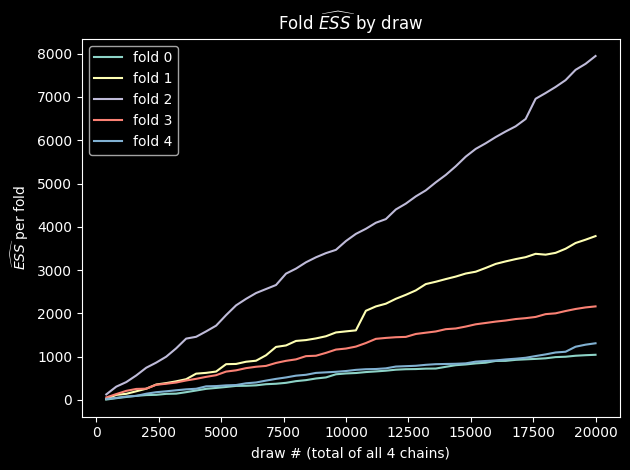

In [8]:
plt.plot(results['draws'], results['ess'])
plt.title(r'Fold $\widehat{ESS}$ by draw')
plt.legend([f'fold {i}' for i in range(5)])
plt.xlabel('draw # (total of all 4 chains)')
plt.ylabel(r'$\widehat{ESS}$ per fold')
plt.tight_layout()
plt.show()

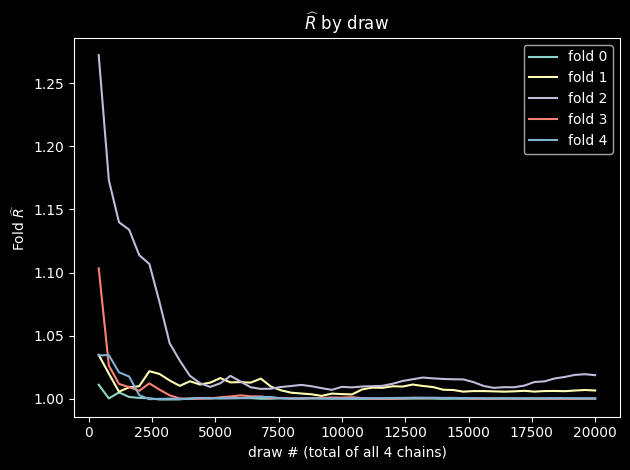

In [9]:
plt.plot(results['draws'], results['rhat'])
plt.title(r'$\widehat{R}$ by draw')
plt.legend([f'fold {i}' for i in range(5)])
plt.xlabel('draw # (total of all 4 chains)')
plt.ylabel(r'Fold $\widehat{R}$')
plt.tight_layout()
plt.show()

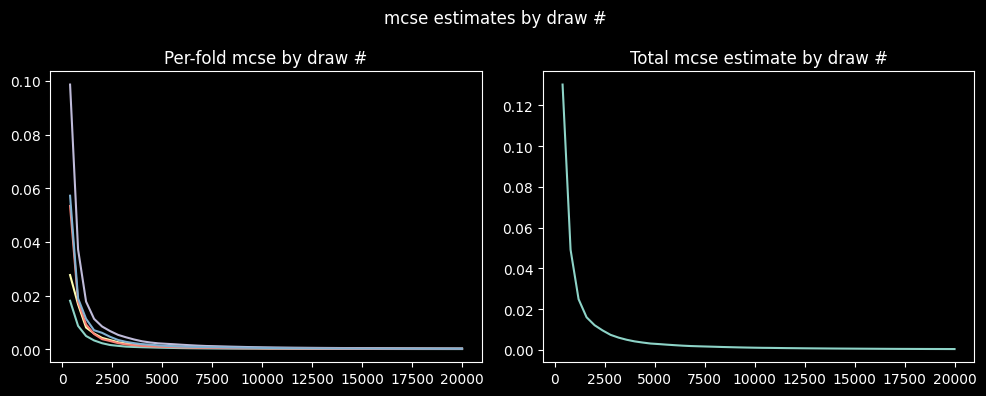

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
each, total = axes
mcse = results['mcse']
each.plot(results['draws'], mcse)
each.set_title('Per-fold mcse by draw #')
total_mcse = jnp.sqrt(jnp.sum(mcse**2, axis=1))
total.plot(results['draws'], total_mcse)
total.set_title('Total mcse estimate by draw #')
fig.suptitle('mcse estimates by draw #')
fig.tight_layout()
plt.show()

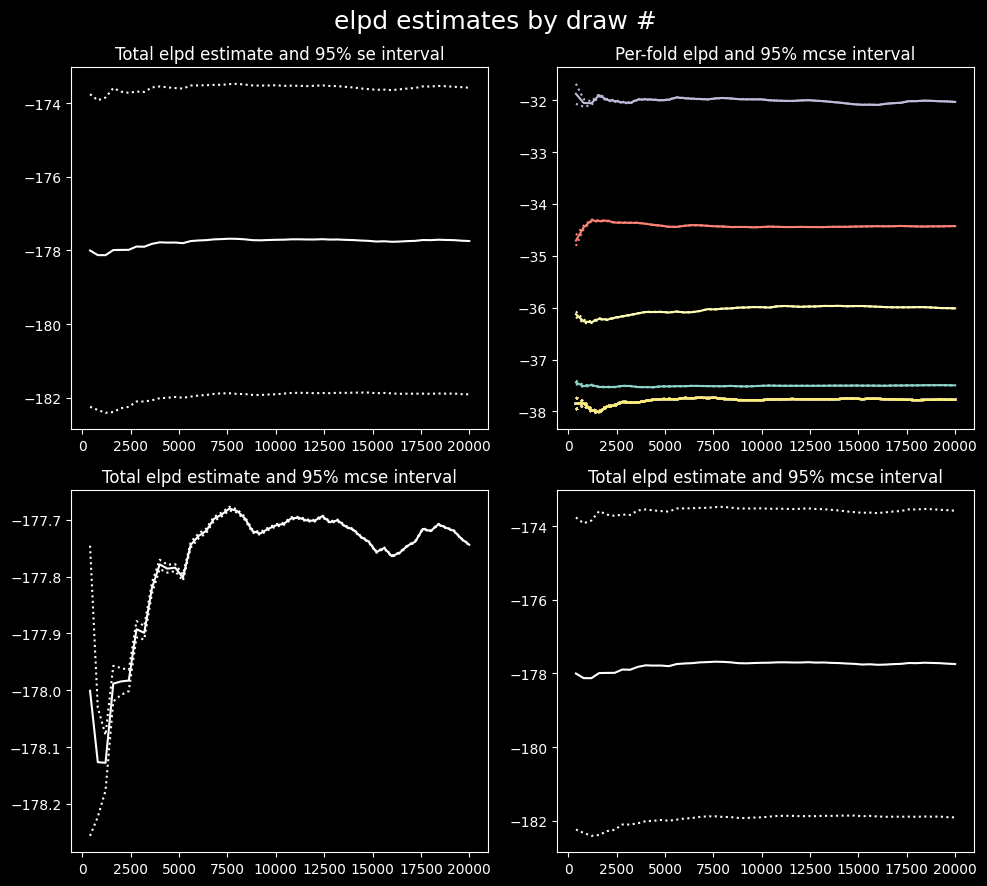

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
((p_total, p_each), (p_total_mcse, p_total_cvse)) = axes
draws, elpd = results['draws'], results['elpd']
total_elpd = jnp.sum(results['elpd'], axis=1)
total_mcse = jnp.sqrt(jnp.sum(mcse**2, axis=1))
total_cvse = jnp.sqrt(jnp.var(elpd, axis=1))
total_se = jnp.sqrt(total_mcse**2 + jnp.var(elpd, axis=1))

p_total.plot(results['draws'], total_elpd, color='white')
p_total.plot(results['draws'], total_elpd + 1.96 * total_se, linestyle=':', color='white')
p_total.plot(results['draws'], total_elpd - 1.96 * total_se, linestyle=':', color='white')
p_total.set_title('Total elpd estimate and 95% se interval')

K = elpd.shape[0]
for k in range(K):
    line = p_each.plot(draws, elpd[:,k])
    p_each.plot(draws, elpd[:,k] + 1.96 * mcse[:,k], linestyle=':', color=line[0].get_color())
    p_each.plot(draws, elpd[:,k] - 1.96 * mcse[:,k], linestyle=':', color=line[0].get_color())
p_each.set_title('Per-fold elpd and 95% mcse interval')

p_total_mcse.plot(results['draws'], total_elpd, color='white')
p_total_mcse.plot(results['draws'], total_elpd + 1.96 * total_mcse, linestyle=':', color='white')
p_total_mcse.plot(results['draws'], total_elpd - 1.96 * total_mcse, linestyle=':', color='white')
p_total_mcse.set_title('Total elpd estimate and 95% mcse interval')

p_total_cvse.plot(results['draws'], total_elpd, color='white')
p_total_cvse.plot(results['draws'], total_elpd + 1.96 * total_cvse, linestyle=':', color='white')
p_total_cvse.plot(results['draws'], total_elpd - 1.96 * total_cvse, linestyle=':', color='white')
p_total_cvse.set_title('Total elpd estimate and 95% mcse interval')

fig.suptitle('elpd estimates by draw #', fontsize=18)
fig.tight_layout()
plt.show()

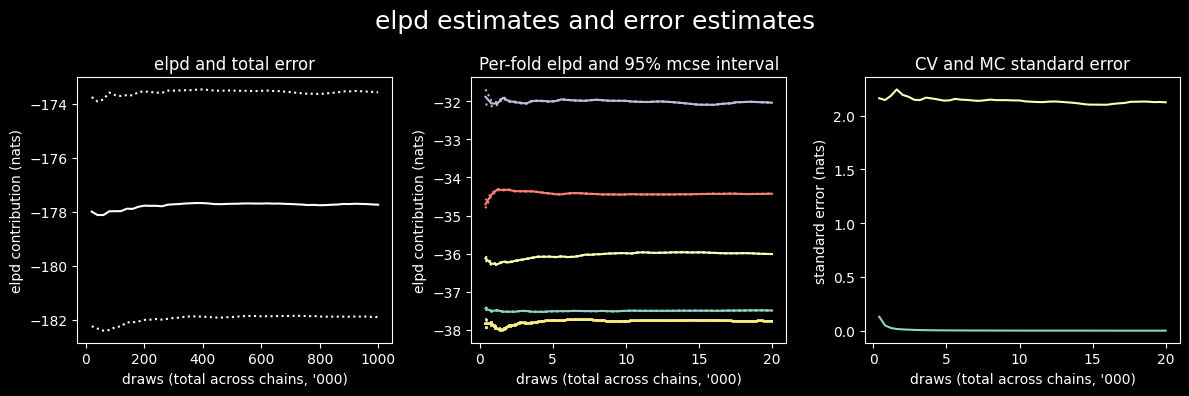

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
p_total, p_each, p_se = axes
draws, elpd = results['draws'], results['elpd']
kdraws = draws * 1e-3
K = elpd.shape[0]
total_elpd = results['total_elpd']
total_mcse = results['total_mcse']
total_cvse = results['total_cvse']
total_se = results['total_se']

p_total.plot(kdraws*K, total_elpd, color='white')
p_total.plot(kdraws*K, total_elpd + 1.96 * total_se, linestyle=':', color='white')
p_total.plot(kdraws*K, total_elpd - 1.96 * total_se, linestyle=':', color='white')
p_total.set_title('elpd and total error')
p_total.set_ylabel('elpd contribution (nats)')

K = elpd.shape[0]
for k in range(K):
    line = p_each.plot(kdraws, elpd[:,k])
    p_each.plot(kdraws, elpd[:,k] + 1.96 * mcse[:,k], linestyle=':', color=line[0].get_color())
    p_each.plot(kdraws, elpd[:,k] - 1.96 * mcse[:,k], linestyle=':', color=line[0].get_color())
p_each.set_title('Per-fold elpd and 95% mcse interval')
p_each.set_ylabel('elpd contribution (nats)')

p_se.plot(kdraws, total_mcse)
p_se.plot(kdraws, total_cvse)
p_se.set_title('CV and MC standard error')
p_se.set_ylabel('standard error (nats)')

for ax in axes:
    ax.set_xlabel("draws (total across chains, '000)")

fig.suptitle('elpd estimates and error estimates', fontsize=18)
fig.tight_layout()
plt.show()